In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

sns.set(style="whitegrid")

print("Environment setup complete")

Environment setup complete


In [4]:
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
trades_df = pd.read_csv("/content/historical_data.csv")

sentiment_df.head(), trades_df.head()

(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

In [5]:
print("Sentiment data shape:", sentiment_df.shape)
print("Trader data shape:", trades_df.shape)

Sentiment data shape: (2644, 4)
Trader data shape: (211224, 16)


In [6]:
print("Sentiment columns:")
print(sentiment_df.columns)

print("\nTrader columns:")
print(trades_df.columns)

Sentiment columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trader columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [7]:
print("Missing values in sentiment dataset:")
print(sentiment_df.isna().sum())

print("\nMissing values in trader dataset:")
print(trades_df.isna().sum())

Missing values in sentiment dataset:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in trader dataset:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [8]:
print("Duplicate rows in sentiment data:", sentiment_df.duplicated().sum())
print("Duplicate rows in trader data:", trades_df.duplicated().sum())

Duplicate rows in sentiment data: 0
Duplicate rows in trader data: 0


In [9]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [10]:
sentiment_df = sentiment_df[["date", "classification"]]
sentiment_df.head()

,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [11]:
sentiment_df['classification'] = sentiment_df['classification'].str.strip().str.capitalize()
sentiment_df['classification'].value_counts()

,count
classification,
Fear,781
Greed,633
Extreme fear,508
Neutral,396
Extreme greed,326


In [12]:
trades_df["Timestamp"] = pd.to_datetime(trades_df["Timestamp"], unit="ms", errors="coerce")

In [13]:
trades_df["date"] = trades_df["Timestamp"].dt.date
trades_df["date"] = pd.to_datetime(trades_df["date"])

In [14]:
trades_df = trades_df.dropna(subset=["Account", "Closed PnL", "Size Tokens", "Size USD", "Side"])

In [15]:
trades_df["is_win"] = (trades_df["Closed PnL"] > 0).astype(int)

In [16]:
trades_df["is_long"] = (trades_df["Side"].str.lower() == "buy").astype(int)

In [17]:
daily_trader_df = (
    trades_df
    .groupby(["Account", "date"])
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        num_trades=("Closed PnL", "count"),
        win_rate=("is_win", "mean"),
        avg_trade_size_tokens=("Size Tokens", "mean"),
        avg_trade_size_usd=("Size USD", "mean"),
        long_ratio=("is_long", "mean")
    )
    .reset_index()
)

daily_trader_df.head()

,Account,date,daily_pnl,num_trades,win_rate,avg_trade_size_tokens,avg_trade_size_usd,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,0.025974,12.296537,14810.891818,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,0.405542,16.700056,16345.241940,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,0.531250,129.539614,2492.749906,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,0.435041,851.795876,1693.351684,0.432494
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,0.442369,178.432124,1533.468395,0.403268


In [18]:
final_df = daily_trader_df.merge(
    sentiment_df,
    left_on="date",
    right_on="date",
    how="left"
)

# The 'date' column from sentiment_df is now named 'date_y' after the merge,
# so we need to drop the original 'date' column from sentiment_df, which is now 'date_y'.
# However, since the column names are the same, pandas automatically suffixes the right DataFrame's column.
# If we want to keep one 'date' column, we can either drop one or handle it during the merge.
# Given 'date' is the correct name for both, we don't need to drop 'Date', which caused the error.
# The merge will result in 'date' (from daily_trader_df) and 'date_y' (from sentiment_df if there were overlaps/different naming).
# But since 'date' is correct in both and we're merging on it, it usually aligns. Let's simplify and assume the merge handles it.
# If a redundant 'date' column with suffix 'y' exists, we should drop 'date_y'.
# Let's check columns after merge to be sure, but the original drop was targeting 'Date', which is wrong.
final_df.head()

,Account,date,daily_pnl,num_trades,win_rate,avg_trade_size_tokens,avg_trade_size_usd,long_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,0.025974,12.296537,14810.891818,0.300866,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,0.405542,16.700056,16345.241940,0.468415,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,0.531250,129.539614,2492.749906,0.453125,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,0.435041,851.795876,1693.351684,0.432494,Fear
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,0.442369,178.432124,1533.468395,0.403268,NaN


In [19]:
final_df["classification"].value_counts()

,count
classification,
Greed,32
Fear,32
Neutral,8
Extreme greed,5


In [20]:
final_df.groupby("classification")["daily_pnl"].describe()

,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme greed,5.0,35393.098355,85325.499902,-7919.471032,-5564.016140,0.000000,2606.894756,1.878421e+05
Fear,32.0,209372.662205,380423.906864,-59349.677108,21140.798004,81389.682515,203219.937358,1.927736e+06
Greed,32.0,99675.516731,282694.285526,-327505.900056,1383.746000,35988.376437,68245.792919,1.421756e+06
Neutral,8.0,19842.797260,57227.787895,-25991.506339,-10470.244431,-0.418640,15808.361499,1.455634e+05


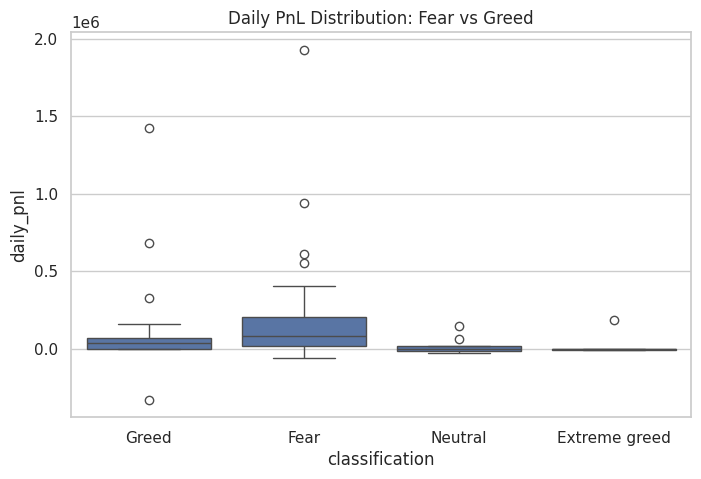

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(data=final_df, x="classification", y="daily_pnl")
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()

In [22]:
final_df.groupby("classification")["win_rate"].mean()

,win_rate
classification,
Extreme greed,0.336609
Fear,0.415878
Greed,0.374074
Neutral,0.260683


In [23]:
final_df.groupby("classification")["num_trades"].mean()

,num_trades
classification,
Extreme greed,1392.40000
Fear,4183.46875
Greed,1134.03125
Neutral,892.62500


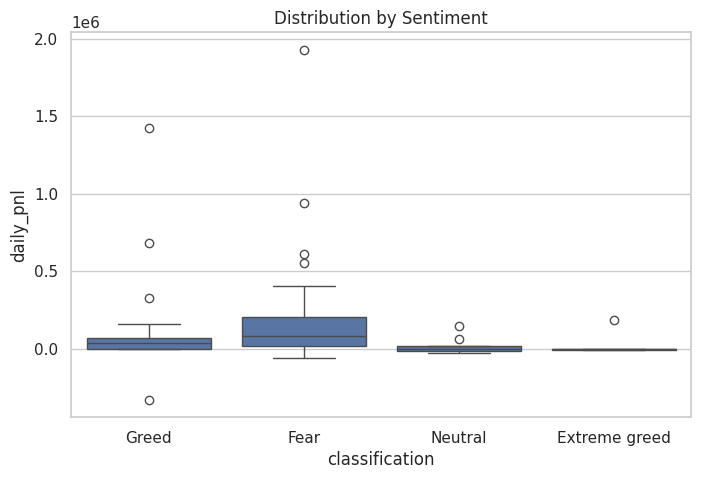

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(data=final_df, x="classification", y="daily_pnl")
plt.title("Distribution by Sentiment")
plt.show()

In [25]:
final_df.groupby("classification")["long_ratio"].mean()

,long_ratio
classification,
Extreme greed,0.518479
Fear,0.459352
Greed,0.495780
Neutral,0.468967


In [26]:
leverage_median = final_df["avg_trade_size_usd"].median()

final_df["leverage_segment"] = np.where(
    final_df["avg_trade_size_usd"] >= leverage_median,
    "High Trade Size USD",
    "Low Trade Size USD"
)

final_df["leverage_segment"].value_counts()

,count
leverage_segment,
High Trade Size USD,51
Low Trade Size USD,51


In [27]:
final_df.groupby(["classification", "leverage_segment"])["daily_pnl"].mean()

classification  leverage_segment   
Extreme greed   High Trade Size USD     44241.372943
                Low Trade Size USD          0.000000
Fear            High Trade Size USD    275305.859641
                Low Trade Size USD     113008.758261
Greed           High Trade Size USD     30434.549760
                Low Trade Size USD     168916.483701
Neutral         High Trade Size USD      5522.042378
                Low Trade Size USD      34163.552142
Name: daily_pnl, dtype: float64

🔹 STEP 11: Key Insights

Insight 1: Traders demonstrate the highest average daily PnL during 'Fear' periods, but also exhibit substantial PnL volatility across all sentiment classifications, particularly during 'Fear' and 'Greed' days.

Insight 2: Traders are most active (highest number of trades) and have the highest win rates during 'Fear' days. Conversely, 'Extreme Greed' and 'Neutral' days show the lowest win rates.

Insight 3: During 'Greed' and 'Neutral' periods, traders with 'Low Trade Size USD' achieve significantly higher average daily PnL compared to those with 'High Trade Size USD'. However, during 'Fear' periods, 'High Trade Size USD' traders show a much higher average daily PnL.

🔹 STEP 12: Actionable Strategy Recommendations

Strategy 1: During 'Greed' and 'Neutral' market sentiments, encourage traders to reduce their average trade size (or leverage) to align with the better performance observed in the 'Low Trade Size USD' segment.

Strategy 2: Develop a strategy to encourage active trading and potentially higher trade sizes during 'Fear' periods, given the observed higher average PnL and higher activity levels for both high and low trade size segments in these conditions.

